# Purpose


This notebook demonstrates the data pipeline from raw tables to analytical datasets. At the end of this activity, train & test data sets are created from raw data.



## Imports

In [1]:
from pprint import pprint
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.options.mode.use_inf_as_na = True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings

warnings.filterwarnings('ignore', message="The default value of regex will change from True to False in a future version.", 
                        category=FutureWarning)

## Utility functions

# 1. Initialization

In [4]:
sales_df = pd.read_csv("../../data/raw/sales/sales_data.csv")
social_media_df = pd.read_csv('../../data/raw/sales/social_media_data_csv.csv')
google_search = pd.read_csv('../../data/raw/sales/google_search_data.csv')
product_manufacturer = pd.read_csv('../../data/raw/sales/product_manufacturer_list.csv')
Theme_list = pd.read_csv('../../data/raw/sales/Theme_list.csv')
Theme_product_list = pd.read_csv('../../data/raw/sales/Theme_product_list.csv')

# 2. Data cleaning and consolidation

In [5]:
google_search_data_with_theme = google_search.merge(Theme_list, left_on='Claim_ID', right_on='CLAIM_ID')

social_media_data_with_theme = social_media_df.merge(Theme_list, how='left', left_on='Theme Id', right_on='CLAIM_ID')

sales_with_product = sales_df.merge(product_manufacturer, left_on='product_id', right_on='PRODUCT_ID', how='inner')
print(sales_with_product.shape)

(4526182, 7)


In [6]:
# Formatting date columns
google_search_data_with_theme['date'] = pd.to_datetime(google_search_data_with_theme['date'], dayfirst=True)

# Convert "published_date" column to datetime
social_media_data_with_theme['published_date'] = pd.to_datetime(social_media_data_with_theme['published_date'], dayfirst=True)

# Convert the int64 column to datetime using the specified format
# sales_with_theme_product['system_calendar_key_N'] = pd.to_datetime(sales_with_theme_product['system_calendar_key_N'], format='%Y%m%d')

# # Convert the datetime column to the desired format
# sales_with_theme_product['system_calendar_key_N'] = sales_with_theme_product['system_calendar_key_N'].dt.strftime('%d-%m-%Y')

# # Convert "system_calendar_key_N" column to datetime
# sales_with_theme_product['system_calendar_key_N'] = pd.to_datetime(sales_with_theme_product['system_calendar_key_N'], dayfirst=True)

### Provide the list of themes available across all data sources


In [7]:
google_search_theme_list = list(google_search_data_with_theme["Claim Name"].unique())
social_media_theme_list = list(social_media_data_with_theme["Claim Name"].unique())

In [8]:
themes = list(set().union(google_search_theme_list, social_media_theme_list))

In [9]:
print(themes)

[nan, 'added fiber', 'single shot', 'cranberry', 'halal', 'ethical - packaging', 'snickerdoodle', 'sausage', 'scallop', 'strawberry', 'low carb', 'organic', 'ethnic & exotic', 'high/source of fiber', 'rabbit', 'skin health', 'added calcium', 'cinnamon', 'carob', 'dha', 'ethical - not specific', 'ricotta cheese', 'low sugar', 'chili', 'cream', 'convenience - easy-to-prepare', 'sweet potato', 'red tomato', 'refill', 'ethical', 'quail', 'caramel', 'dry', 'shortbread', 'lobster', 'french bisque', 'pheasant', 'banana', 'digestive/gut health', 'pomegranate', 'sugar free', 'blackberry', 'traditional', 'vitamin/mineral fortified', 'ethical - environment', 'health (active)', 'convenience - consumption', 'honey', 'rosemary', 'low calorie', 'blood orange', 'antioxidant', 'lactose free', 'hickory smoked', 'low gi', 'energy/alertness', 'trout', 'low fat', 'no added sugar', 'sea salt', 'gingerbread', 'fish', 'cashew nut', 'poultry', 'salmon', 'red apple', 'orange', 'convenience - ready prepared', 'f

- There are 195 themes across google search and social media platforms.

## Understands consumer preference(themes) available in each data source


### Google Search with Theme Table

In [10]:
google_search_data_with_theme['quarter'] = google_search_data_with_theme['date'].dt.quarter
google_search_data_with_theme.head()

,date,platform,searchVolume,Claim_ID,week_number,year_new,CLAIM_ID,Claim Name,quarter
0,2014-01-05,google,349,916,1,2014,916,gluten free,1
1,2014-01-06,google,349,916,2,2014,916,gluten free,1
2,2014-01-07,google,697,916,2,2014,916,gluten free,1
3,2014-01-10,google,349,916,2,2014,916,gluten free,1
4,2014-01-20,google,697,916,4,2014,916,gluten free,1


In [11]:
platform_level = google_search_data_with_theme.groupby(['platform'])['searchVolume'].sum().reset_index()
Total = google_search_data_with_theme['searchVolume'].sum()

In [12]:
platform_level['Share'] = (platform_level['searchVolume']/Total)*100
platform_level

,platform,searchVolume,Share
0,amazon,10115655,0.956729
1,chewy,3078446,0.291157
2,google,1043225182,98.667264
3,walmart,897136,0.084850


-- Google is contributing around 99% hence we can ignore other platforms

In [13]:
df_2018 = google_search_data_with_theme[google_search_data_with_theme['year_new'] >= 2018].groupby(['platform'])['searchVolume'].sum().reset_index()
Total_2018 = google_search_data_with_theme[google_search_data_with_theme['year_new'] >= 2018]['searchVolume'].sum()
df_2018['Share'] = (df_2018['searchVolume']/Total_2018)*100
df_2018

,platform,searchVolume,Share
0,amazon,10115655,2.661913
1,chewy,3078446,0.810086
2,google,365923244,96.291921
3,walmart,897136,0.236079


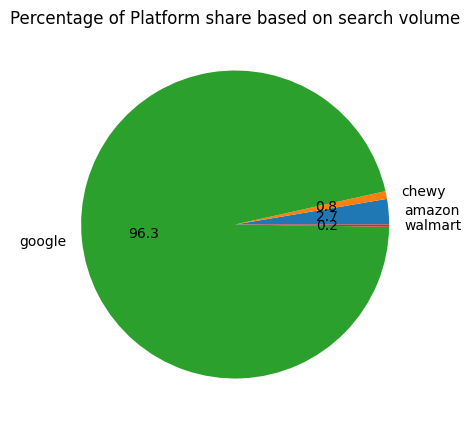

In [14]:
plt.figure(figsize=(6,5))
plt.pie(df_2018['Share'], labels = df_2018['platform'], autopct='%.1f')
plt.title('Percentage of Platform share based on search volume')
plt.show()

- we have considerd data from 2018 only since there is no platform other Google before 2018
- There are 3 months of data missing in 2018 calendar year

In [15]:
google_data = google_search_data_with_theme.groupby(['year_new', 'quarter', 'platform', 'Claim Name'])['searchVolume'].sum().reset_index()
top_5_claim_names_google = google_data.sort_values(['year_new', 'quarter', 'searchVolume'], ascending=[True, True, False])
top_5_claim_names_google = top_5_claim_names_google.groupby(['year_new', 'quarter']).head(5)

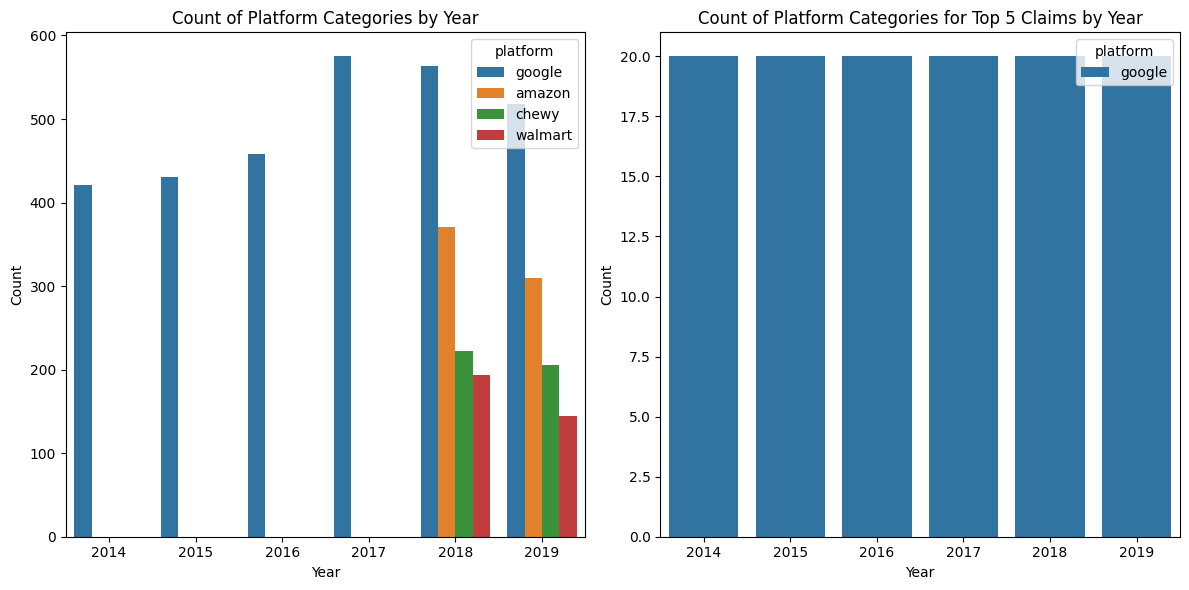

In [16]:
# Group the data by year and platform, and count the occurrences
platform_counts = google_data.groupby(['year_new', 'platform']).size().reset_index(name='count')
platform_counts_top_5_claims = top_5_claim_names_google.groupby(['year_new', 'platform']).size().reset_index(name='count')

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the bar plot for platform counts
sns.barplot(data=platform_counts, x='year_new', y='count', hue='platform', ax=axs[0])

# Set labels and title for the first subplot
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Count')
axs[0].set_title('Count of Platform Categories by Year')

# Plot the bar plot for top 5 claim names
sns.barplot(data=platform_counts_top_5_claims, x='year_new', y='count', hue='platform', ax=axs[1])

# Set labels and title for the second subplot
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Count')
axs[1].set_title('Count of Platform Categories for Top 5 Claims by Year')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
google_search_data_with_theme.head()

,date,platform,searchVolume,Claim_ID,week_number,year_new,CLAIM_ID,Claim Name,quarter
0,2014-01-05,google,349,916,1,2014,916,gluten free,1
1,2014-01-06,google,349,916,2,2014,916,gluten free,1
2,2014-01-07,google,697,916,2,2014,916,gluten free,1
3,2014-01-10,google,349,916,2,2014,916,gluten free,1
4,2014-01-20,google,697,916,4,2014,916,gluten free,1


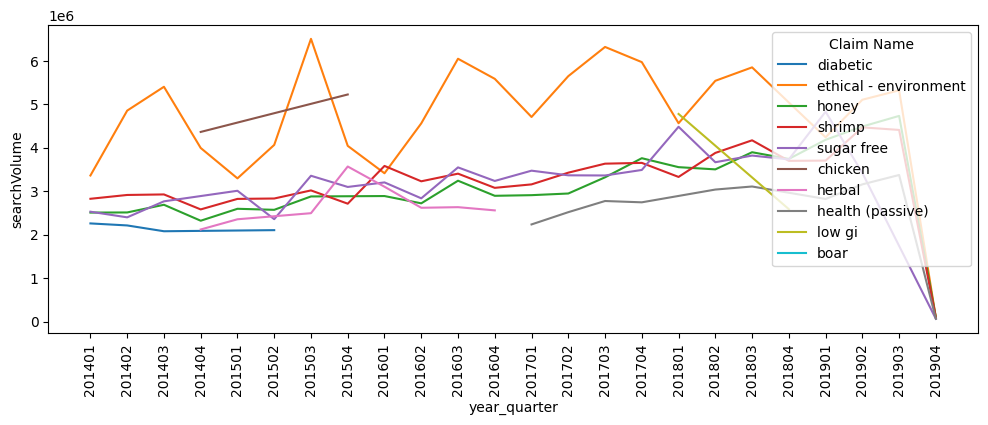

In [18]:
top_5_claim_names_google.drop('platform', axis=1, inplace=True)

top_5_claim_names_google['quarter'] = top_5_claim_names_google['quarter'].apply(lambda x: str(x) if x>9 else '0'+str(x))
top_5_claim_names_google['year_new'] = top_5_claim_names_google['year_new'].astype(str)
top_5_claim_names_google['year_quarter'] = top_5_claim_names_google['year_new']+top_5_claim_names_google['quarter']

year_quarter_search = top_5_claim_names_google.groupby(['year_quarter', 'Claim Name'])['searchVolume'].sum().reset_index()
year_search = top_5_claim_names_google.groupby(['year_new', 'Claim Name'])['searchVolume'].sum().reset_index()

plt.figure(figsize=(12,4))
sns.lineplot(x='year_quarter', y='searchVolume', data=year_quarter_search, hue='Claim Name')
plt.xticks(rotation=90,size=10,color='black')
plt.show()

In [19]:
# google_search_data_with_theme['quarter'] = google_search_data_with_theme['date'].dt.year
# google_search_data_with_theme.groupby(['year_new', 'quarter'])['searchVolume'].sum().reset_index().to_csv('year_quarter.csv', index=False)

- Ethical enviornment reamins the top priority across all the claims
- shrimp and Sugar free follows ethical enviornment and remains next top claims
- The current trend looks like Ethical enviornment, honey and shrimp sit at the top of the table

### Social Media With Theme Table

In [20]:
# Extract the year from the "published_date" column
social_media_data_with_theme['year_of_publishing'] = social_media_data_with_theme['published_date'].dt.year

In [21]:
social_media_data_with_theme['quarter'] = social_media_data_with_theme['published_date'].dt.quarter
social_media_data_with_theme.head()

,Theme Id,published_date,total_post,CLAIM_ID,Claim Name,year_of_publishing,quarter
0,148.0,2015-01-10,76,148.0,tuna,2015,1
1,148.0,2015-10-10,31,148.0,tuna,2015,4
2,148.0,2015-11-10,65,148.0,tuna,2015,4
3,148.0,2015-12-10,88,148.0,tuna,2015,4
4,148.0,2015-10-13,85,148.0,tuna,2015,4


In [22]:
social_media_data_with_theme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533390 entries, 0 to 533389
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Theme Id            314879 non-null  float64       
 1   published_date      533390 non-null  datetime64[ns]
 2   total_post          533390 non-null  int64         
 3   CLAIM_ID            314879 non-null  float64       
 4   Claim Name          314879 non-null  object        
 5   year_of_publishing  533390 non-null  int32         
 6   quarter             533390 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(1)
memory usage: 24.4+ MB


In [23]:
# top_3_claim_names_social_media = social_media_data_with_theme.groupby(['year_of_publishing', 'quarter', 'Claim Name'])['total_post'].sum().reset_index()
# top_3_claim_names_social_media = top_3_claim_names_social_media.sort_values(['year_of_publishing', 'quarter', 'total_post'], ascending=[True, True, False])
# top_3_claim_names_social_media = top_3_claim_names_social_media.groupby(['year_of_publishing', 'quarter']).head(3)

# top_3_claim_names_social_media.to_csv('top_3_claim_names_social_media.csv', index=False)

In [24]:
# top_5_claim_names_social_media.info()
social_media_data_with_theme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533390 entries, 0 to 533389
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Theme Id            314879 non-null  float64       
 1   published_date      533390 non-null  datetime64[ns]
 2   total_post          533390 non-null  int64         
 3   CLAIM_ID            314879 non-null  float64       
 4   Claim Name          314879 non-null  object        
 5   year_of_publishing  533390 non-null  int32         
 6   quarter             533390 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(1)
memory usage: 24.4+ MB


In [25]:
top_5_claim_names_social_media = social_media_data_with_theme.groupby(['year_of_publishing', 'quarter', 'Claim Name'])['total_post'].sum().reset_index()
top_5_claim_names_social_media = top_5_claim_names_social_media.sort_values(['year_of_publishing', 'quarter', 'total_post'], ascending=[True, True, False])
top_5_claim_names_social_media = top_5_claim_names_social_media.groupby(['year_of_publishing', 'quarter']).head(5)

In [26]:
top_5_claim_names_social_media.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 0 to 3530
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   year_of_publishing  96 non-null     int32 
 1   quarter             96 non-null     int32 
 2   Claim Name          96 non-null     object
 3   total_post          96 non-null     int64 
dtypes: int32(2), int64(1), object(1)
memory usage: 3.0+ KB


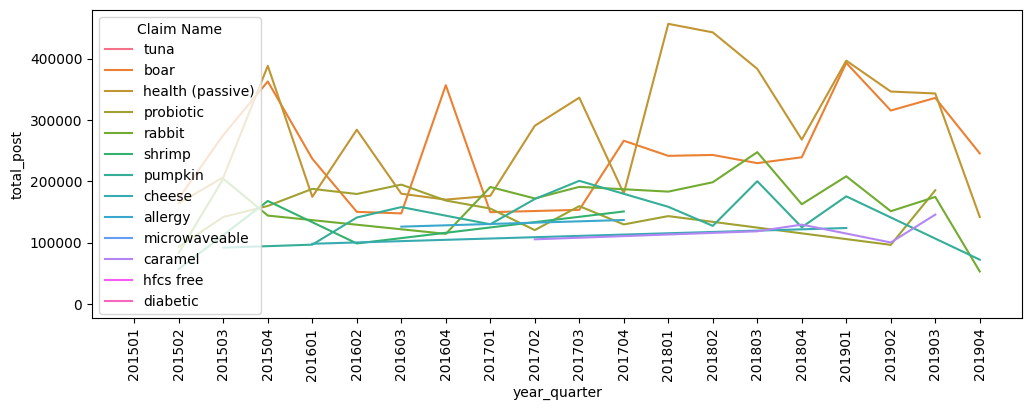

In [27]:
top_5_claim_names_social_media['quarter'] = top_5_claim_names_social_media['quarter'].apply(lambda x: str(x) if x>9 else '0'+str(x))
top_5_claim_names_social_media['year_of_publishing'] = top_5_claim_names_social_media['year_of_publishing'].astype(str)
top_5_claim_names_social_media['year_quarter'] = top_5_claim_names_social_media['year_of_publishing']+top_5_claim_names_social_media['quarter']


# top_5_claim_names_social_media.head()

year_quarter_post = top_5_claim_names_social_media.groupby(['year_quarter', 'Claim Name'])['total_post'].sum().reset_index()
year_post = top_5_claim_names_social_media.groupby(['year_of_publishing', 'Claim Name'])['total_post'].sum().reset_index()

plt.figure(figsize=(12,4))
sns.lineplot(x='year_quarter', y='total_post', data=year_quarter_post, hue='Claim Name')
plt.xticks(rotation=90,size=10,color='black')
plt.show()

### Sales with Theme Product Table

In [28]:
sales_with_theme_product = sales_with_product.merge(Theme_product_list, left_on='PRODUCT_ID',right_on='PRODUCT_ID', how='inner')
print(sales_with_theme_product.shape)

sales_with_theme_product = sales_with_theme_product.merge(Theme_list, on='CLAIM_ID', how='inner')
print(sales_with_theme_product.shape)

(7767420, 8)
(7767420, 9)


In [29]:
# Convert the int64 column to datetime using the specified format
sales_with_theme_product['system_calendar_key_N'] = pd.to_datetime(sales_with_theme_product['system_calendar_key_N'], format='%Y%m%d')

# Convert the datetime column to the desired format
sales_with_theme_product['system_calendar_key_N'] = sales_with_theme_product['system_calendar_key_N'].dt.strftime('%d-%m-%Y')

# Convert "system_calendar_key_N" column to datetime
sales_with_theme_product['system_calendar_key_N'] = pd.to_datetime(sales_with_theme_product['system_calendar_key_N'], dayfirst=True)

In [30]:
# Extract the year from the "system_calendar_key_N" column
sales_with_theme_product['Year'] = sales_with_theme_product['system_calendar_key_N'].dt.year

# Change column name "system_calendar_key_N" to "Date"
sales_with_theme_product.rename(columns={'system_calendar_key_N': 'Date'}, inplace=True)

# Drop the "product_id" column
sales_with_theme_product.drop('product_id', axis=1, inplace=True)

# Remove records where "Claim Name" is "No Claim"
sales_with_theme_product = sales_with_theme_product[sales_with_theme_product['Claim Name'] != 'No Claim']

<Axes: xlabel='Year', ylabel='sales_units_value'>

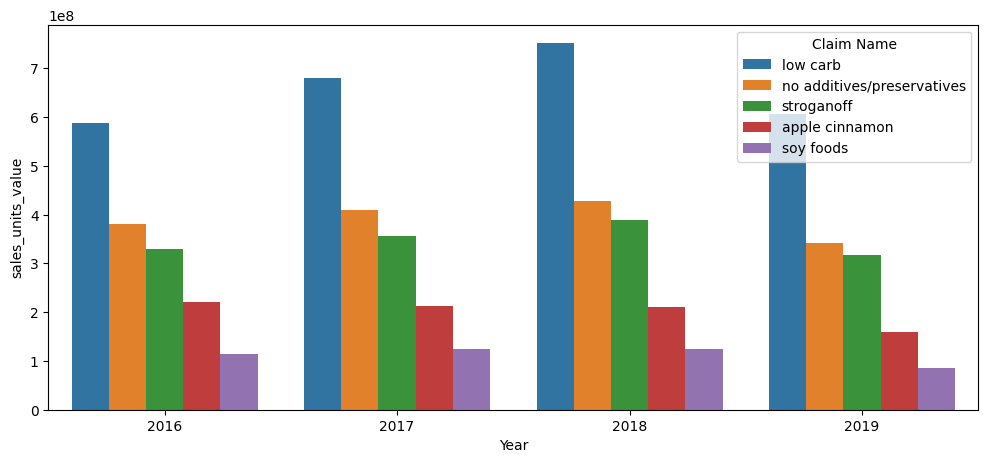

In [32]:
grouped_data_3 = sales_with_theme_product.groupby(["Year", "Claim Name"])["sales_units_value"].sum().reset_index()

# del sorted_data

# Sort the data by year and searchVolume in descending order
sorted_data = grouped_data_3.sort_values(["Year", "sales_units_value"], ascending=[True, False])

del grouped_data_3

# Get the top 5 Claim Names for each year
top_5_claim_names_throgh_sales_units = sorted_data.groupby("Year").head(5)

plt.figure(figsize=(12,5))
sns.barplot(data=top_5_claim_names_throgh_sales_units, x='Year', y='sales_units_value', hue='Claim Name')

In [40]:
sales_with_theme_product.head(2)

,Date,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor,CLAIM_ID,Claim Name,Year,quarter
2045703,2016-01-09,1101.0,159,105,37,Others,158,chicken,2016,1
2045704,2016-01-23,1101.0,159,105,37,Others,158,chicken,2016,1


In [47]:
sales_with_theme_product['quarter'] = sales_with_theme_product['Date'].dt.quarter

top_5_claim_names_sales = sales_with_theme_product.groupby(['Year', 'quarter', 'Claim Name'])['sales_units_value'].sum().reset_index()
top_5_claim_names_sales = top_5_claim_names_sales.sort_values(['Year', 'quarter', 'sales_units_value'], ascending=[True, True, False])
top_5_claim_names_sales = top_5_claim_names_sales.groupby(['Year', 'quarter']).head(5)

In [48]:
top_5_claim_names_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 24 to 702
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               80 non-null     int32 
 1   quarter            80 non-null     int32 
 2   Claim Name         80 non-null     object
 3   sales_units_value  80 non-null     int64 
dtypes: int32(2), int64(1), object(1)
memory usage: 2.5+ KB


In [49]:
top_5_claim_names_sales['quarter'] = top_5_claim_names_sales['quarter'].apply(lambda x: str(x) if x>9 else '0'+str(x))
top_5_claim_names_sales['Year'] = top_5_claim_names_sales['Year'].astype(str)
top_5_claim_names_sales['year_quarter'] = top_5_claim_names_sales['Year']+top_5_claim_names_sales['quarter']

In [50]:
top_5_claim_names_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 24 to 702
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               80 non-null     object
 1   quarter            80 non-null     object
 2   Claim Name         80 non-null     object
 3   sales_units_value  80 non-null     int64 
 4   year_quarter       80 non-null     object
dtypes: int64(1), object(4)
memory usage: 3.8+ KB


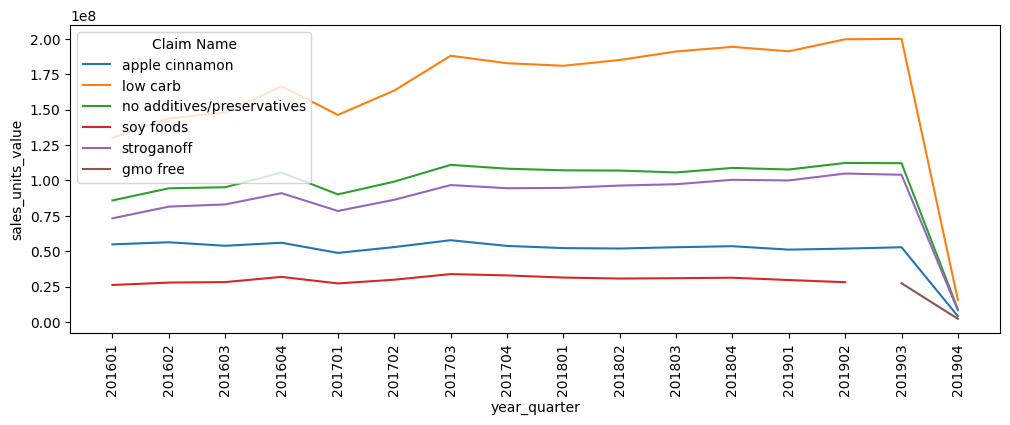

In [51]:
year_quarter_sales = top_5_claim_names_sales.groupby(['year_quarter', 'Claim Name'])['sales_units_value'].sum().reset_index()
year_sales = top_5_claim_names_sales.groupby(['Year', 'Claim Name'])['sales_units_value'].sum().reset_index()

plt.figure(figsize=(12,4))
sns.lineplot(x='year_quarter', y='sales_units_value', data=year_quarter_sales, hue='Claim Name')
plt.xticks(rotation=90,size=10,color='black')
plt.show()

## Provide a report for data sufficiency, sparsity and anomalies in each data source

**1) Data Sufficiency**
- There is no missing data in Google Search and Sales data. Missing values are present in Social Media data.
- In Social Media data, we don't have the "platform" column, like we have in Google Search data. We don't have any "Product name" column for mapping it with "Product ID" column.
- Sales data is only present from 2016 to 2019 year, whereas Google Search and Social Media data is available from 2014 to 2019.

**2) Data Sparsity**
- There is aproximately 41% missing values present in Social Media data for "Theme ID".
- Thre is just 1.39% of 0 values present in Sales data for "sales_dollars_value" and "sales_units_value" column.
- One Product ID has only 1 unique Vendor but is present under multiple Themes.

**3) Anomalies**
- In Sales data, the date column is not formatted in datetime.
- In Social Media data, date column has records with multiple datetime formats.
- There are outliers present across all the 3 datas.

# EDA

## 1) Understand the overall market share of our client

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4526182 entries, 0 to 4526181
Data columns (total 7 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   system_calendar_key_N  datetime64[ns]
 1   product_id             int64         
 2   sales_dollars_value    float64       
 3   sales_units_value      int64         
 4   sales_lbs_value        int64         
 5   PRODUCT_ID             int64         
 6   Vendor                 object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 241.7+ MB


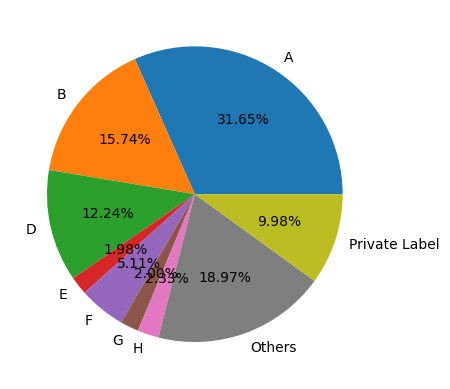

In [64]:
#sales_with_product.head()

# sales_with_product.info()

vendor_level_sales = sales_with_product.groupby(['Vendor'])['sales_dollars_value'].sum().reset_index()
Total_sales = sales_with_product['sales_dollars_value'].sum()

vendor_level_sales['share'] = (vendor_level_sales['sales_dollars_value']/Total_sales)*100

vendor_level_sales

plt.pie(vendor_level_sales['share'], labels=vendor_level_sales['Vendor'], autopct='%1.2f%%')
plt.show()

**Overall market share for Vendor A is 31.65%.**

## 2) Find the potential competitors for our client in each theme


In [67]:
sales_with_theme_product = sales_with_product.merge(Theme_product_list, left_on='PRODUCT_ID',right_on='PRODUCT_ID', how='inner')
print(sales_with_theme_product.shape)

sales_with_theme_product = sales_with_theme_product.merge(Theme_list, on='CLAIM_ID', how='inner')
print(sales_with_theme_product.shape)

(7767420, 8)
(7767420, 9)


In [68]:
# Convert the int64 column to datetime using the specified format
sales_with_theme_product['system_calendar_key_N'] = pd.to_datetime(sales_with_theme_product['system_calendar_key_N'], format='%Y%m%d')

# Convert the datetime column to the desired format
sales_with_theme_product['system_calendar_key_N'] = sales_with_theme_product['system_calendar_key_N'].dt.strftime('%d-%m-%Y')

# Convert "system_calendar_key_N" column to datetime
sales_with_theme_product['system_calendar_key_N'] = pd.to_datetime(sales_with_theme_product['system_calendar_key_N'], dayfirst=True)

In [73]:
# Extract the year from the "system_calendar_key_N" column
sales_with_theme_product['Year'] = sales_with_theme_product['system_calendar_key_N'].dt.year

# Change column name "system_calendar_key_N" to "Date"
sales_with_theme_product.rename(columns={'system_calendar_key_N': 'Date'}, inplace=True)

# Drop the "product_id" column
sales_with_theme_product.drop('product_id', axis=1, inplace=True)

# Remove records where "Claim Name" is "No Claim"
sales_with_theme_product = sales_with_theme_product[sales_with_theme_product['Claim Name'] != 'No Claim']

In [74]:
Vendor_A_Theme_list = list(sales_with_theme_product[sales_with_theme_product.Vendor == 'A']['Claim Name'].unique())

In [75]:
len(Vendor_A_Theme_list)

31

- There are 31 unique claims for Vendor A

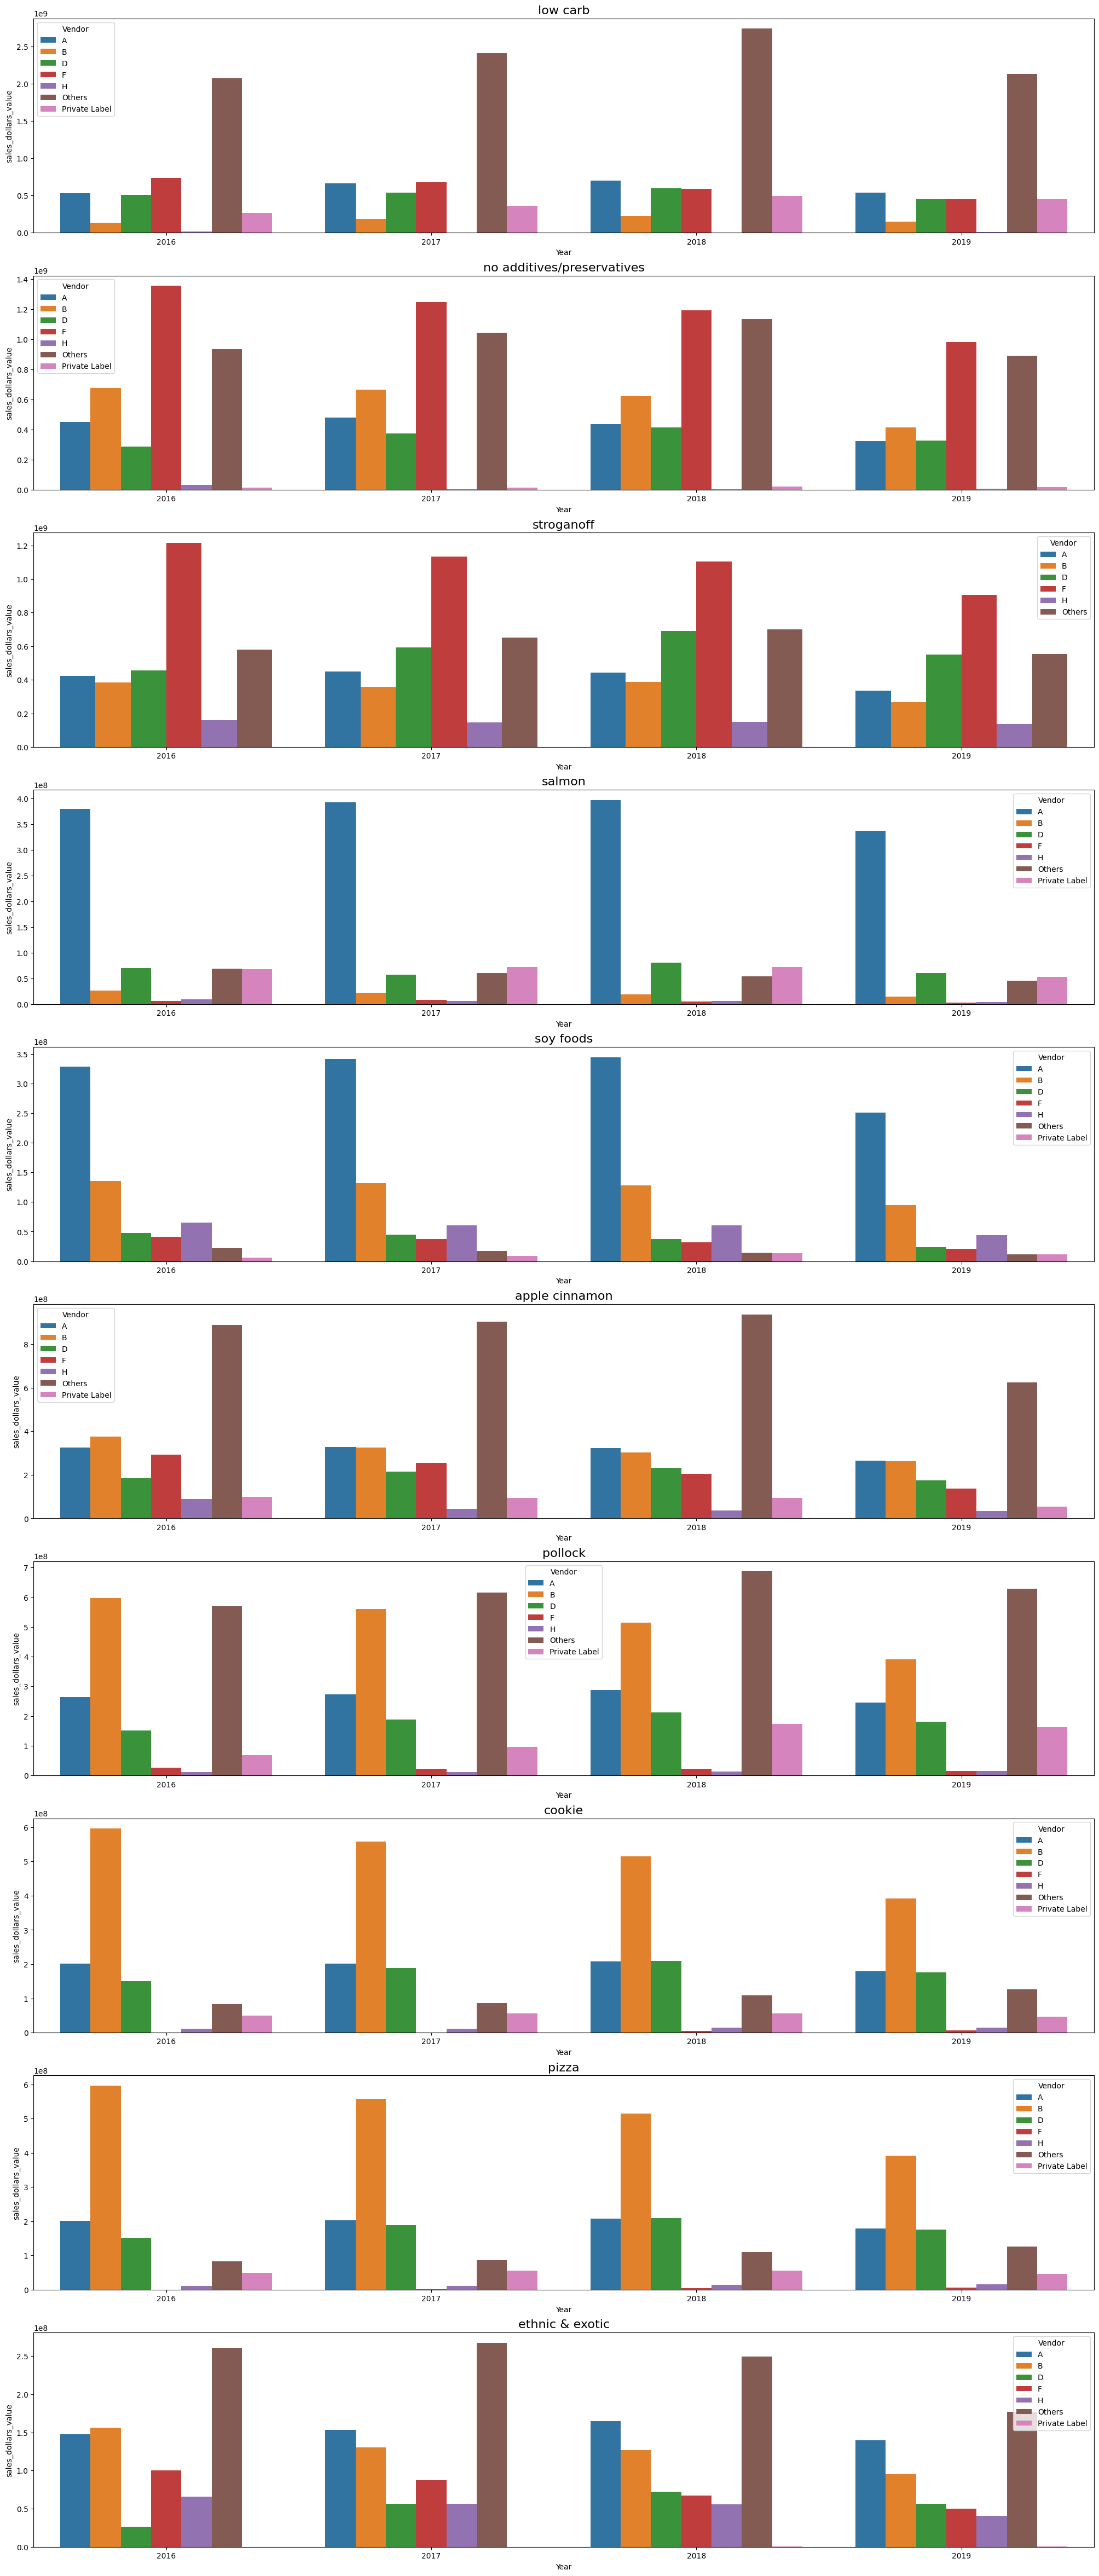

In [77]:
top_10_themes_vendor_A = sales_with_theme_product[sales_with_theme_product.Vendor == 'A'].groupby(['Claim Name'])['sales_dollars_value'].sum().reset_index().sort_values(by='sales_dollars_value', ascending=False).head(10)

top_10_theme_data = sales_with_theme_product[sales_with_theme_product['Claim Name'].isin(list(top_10_themes_vendor_A['Claim Name']))]

vendor_sales_data = top_10_theme_data.groupby(['Year','Claim Name','Vendor'])['sales_dollars_value'].sum().reset_index()

# top_10_theme_data

counter=range(1,len(top_10_themes_vendor_A)+1)
plt.figure(figsize=(25,60))
for i,j in zip(top_10_themes_vendor_A['Claim Name'], counter):
    plt.subplot(10,1,j)
    plt.title(i,fontdict={'fontsize':16,'color':'black'})
    sns.barplot(x='Year',y='sales_dollars_value', data=vendor_sales_data[vendor_sales_data['Claim Name']==i], hue='Vendor')
plt.show()

In the above plots, we have the top 10 themes for Vendor A and we are trying to find the potential competitors for all those themes year wise

1) For "low carb",  Vendor 'D' and "F' are the potential competitors.
2) For "no additives/preservatives",  Vendor 'B' and "D' are the potential competitors.
3) For "stronganoff",  Vendor 'B' and "D' are the potential competitors.
4) For "salmon",  there are no potential competitors.
5) For "soy foods",  there are no potential competitors.
6) For "apple cinnamon",  Vendor ,'B', 'D' and "I' are the potential competitors.
7) For "pollock",  Vendor 'B' and "D' are the potential competitors.
8) For "cookie",  Vendor 'D'is the potential competitors.
9) For "pizza",  Vendor 'D' is the potential competitors.
10) For "ethnic & exotic",  Vendor 'B' is the potential competitors.

**Top 5 Business Opportunities:**
- Shrimp
- Honey
- Sugar-free
- Nuts
- Boar

## Final Data Preparation

In [79]:
sales_with_product.head()

,system_calendar_key_N,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor
0,2016-01-09,1,13927.0,934,18680,1,Others
1,2016-01-23,1,12628.0,878,17564,1,Others
2,2016-02-06,1,11379.0,810,16200,1,Others
3,2016-01-30,1,11568.0,821,16424,1,Others
4,2016-02-13,1,10959.0,784,15682,1,Others


In [80]:
sales_with_product['system_calendar_key_N'] = pd.to_datetime(sales_with_product['system_calendar_key_N'], format='%Y%m%d')
sales_with_product.head(2)

,system_calendar_key_N,product_id,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor
0,2016-01-09,1,13927.0,934,18680,1,Others
1,2016-01-23,1,12628.0,878,17564,1,Others


In [81]:
sales_with_product.shape

(4526182, 7)

In [82]:
sales_with_product = sales_with_product[sales_with_product['sales_dollars_value'] != 0]
sales_with_product = sales_with_product[sales_with_product['sales_lbs_value'] != 0]
sales_with_product.shape

(4462965, 7)

In [83]:
sales_with_product['unit_price'] = sales_with_product['sales_dollars_value']/sales_with_product['sales_units_value']
sales_with_product['unit_weight'] = sales_with_product['sales_lbs_value']/sales_with_product['sales_units_value']
sales_with_product.shape

(4462965, 9)

In [84]:
#Checking missing values
sales_with_product.isnull().sum()

system_calendar_key_N    0
product_id               0
sales_dollars_value      0
sales_units_value        0
sales_lbs_value          0
PRODUCT_ID               0
Vendor                   0
unit_price               0
unit_weight              0
dtype: int64

In [85]:
# Extract the year from the "system_calendar_key_N" column
sales_with_product['Year'] = sales_with_product['system_calendar_key_N'].dt.year
sales_with_product['quarter'] = sales_with_product['system_calendar_key_N'].dt.quarter

# Change column name "system_calendar_key_N" to "Date"
sales_with_product.rename(columns={'system_calendar_key_N': 'Date'}, inplace=True)

# Drop the "product_id" column
sales_with_product.drop('product_id', axis=1, inplace=True)

print(sales_with_product.shape)
# # Remove records where "Claim Name" is "No Claim"
# sales_with_theme_product = sales_with_theme_product[sales_with_theme_product['Claim Name'] != 'No Claim']

(4462965, 10)


In [86]:
sales_with_product.head(3)

,Date,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor,unit_price,unit_weight,Year,quarter
0,2016-01-09,13927.0,934,18680,1,Others,14.911135,20.000000,2016,1
1,2016-01-23,12628.0,878,17564,1,Others,14.382688,20.004556,2016,1
2,2016-02-06,11379.0,810,16200,1,Others,14.048148,20.000000,2016,1


In [ ]:
#sales_with_product.groupby(['Year','quarter'])['sales_dollars_value'].sum().reset_index().to_csv('quarter_wise_sales.csv', index=False)

In [ ]:
#sales_with_product.groupby(['Year','quarter'])['sales_units_value'].sum().reset_index().to_csv('quarter_wise_sales_unit_values.csv', index=False)

In [87]:
sales_with_product['price_per_pound'] = sales_with_product['sales_dollars_value']/sales_with_product['sales_lbs_value']

In [88]:
sales_with_theme_product = sales_with_product.merge(Theme_product_list, left_on='PRODUCT_ID',right_on='PRODUCT_ID', how='inner')
#print(sales_with_theme_product.shape)


In [89]:
sales_with_theme_product = sales_with_theme_product.merge(Theme_list, on='CLAIM_ID', how='inner')
#print(sales_with_theme_product.shape)

In [90]:
print(sales_with_theme_product.shape)
#sales_with_theme_product.tail(5)

(7684901, 13)


In [91]:
sales_with_theme_product[(sales_with_theme_product['PRODUCT_ID'] == 22457) & (sales_with_theme_product['sales_dollars_value'] == 5387.0)]

,Date,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor,unit_price,unit_weight,Year,quarter,price_per_pound,CLAIM_ID,Claim Name
2509506,2016-01-16,5387.0,162,2435,22457,Others,33.253086,15.030864,2016,1,2.21232,432,apple cinnamon
2862211,2016-01-16,5387.0,162,2435,22457,Others,33.253086,15.030864,2016,1,2.21232,186,pollock
3101337,2016-01-16,5387.0,162,2435,22457,Others,33.253086,15.030864,2016,1,2.21232,222,pizza
3246976,2016-01-16,5387.0,162,2435,22457,Others,33.253086,15.030864,2016,1,2.21232,185,cookie
3479675,2016-01-16,5387.0,162,2435,22457,Others,33.253086,15.030864,2016,1,2.21232,187,blueberry
3697586,2016-01-16,5387.0,162,2435,22457,Others,33.253086,15.030864,2016,1,2.21232,224,american southwest style
3817875,2016-01-16,5387.0,162,2435,22457,Others,33.253086,15.030864,2016,1,2.21232,220,herbs
6199489,2016-01-16,5387.0,162,2435,22457,Others,33.253086,15.030864,2016,1,2.21232,8,low carb
7145168,2016-01-16,5387.0,162,2435,22457,Others,33.253086,15.030864,2016,1,2.21232,81,gmo free
7487462,2016-01-16,5387.0,162,2435,22457,Others,33.253086,15.030864,2016,1,2.21232,39,high/source of protein


In [92]:
sales_with_theme_product[sales_with_theme_product['Vendor'] == 'A']['Claim Name'].nunique()

32

In [93]:
sales_with_theme_product['rank_by_claim'] = sales_with_theme_product.groupby(['Date','sales_dollars_value','sales_units_value','sales_lbs_value','PRODUCT_ID','Vendor','unit_price','unit_weight','Year','quarter','price_per_pound'])['CLAIM_ID'].rank(ascending=False)

In [94]:
sales_with_theme_product[sales_with_theme_product['PRODUCT_ID'] == 22457]

,Date,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor,unit_price,unit_weight,Year,quarter,price_per_pound,CLAIM_ID,Claim Name,rank_by_claim
2509506,2016-01-16,5387.0,162,2435,22457,Others,33.253086,15.030864,2016,1,2.212320,432,apple cinnamon,2.0
2509507,2016-01-09,3529.0,104,1558,22457,Others,33.932692,14.980769,2016,1,2.265083,432,apple cinnamon,2.0
2509508,2016-01-30,10265.0,287,4308,22457,Others,35.766551,15.010453,2016,1,2.382776,432,apple cinnamon,2.0
2509509,2016-01-23,7591.0,212,3184,22457,Others,35.806604,15.018868,2016,1,2.384108,432,apple cinnamon,2.0
2509510,2016-02-06,3158.0,83,1248,22457,Others,38.048193,15.036145,2016,1,2.530449,432,apple cinnamon,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593268,2019-09-07,12021.0,355,5325,22457,Others,33.861972,15.000000,2019,3,2.257465,437,vegetarian,1.0
7593269,2019-09-14,7648.0,214,3207,22457,Others,35.738318,14.985981,2019,3,2.384783,437,vegetarian,1.0
7593270,2019-09-21,8448.0,255,3825,22457,Others,33.129412,15.000000,2019,3,2.208627,437,vegetarian,1.0
7593271,2019-09-28,11514.0,332,4985,22457,Others,34.680723,15.015060,2019,3,2.309729,437,vegetarian,1.0


In [95]:
sales_with_theme_product = sales_with_theme_product[sales_with_theme_product['rank_by_claim'] == 1.0]

In [96]:
print("Before Dropping No Claim records: ",sales_with_theme_product.shape)
sales_with_theme_product = sales_with_theme_product[sales_with_theme_product['Claim Name'] != 'No Claim']
print("After Dropping No Claim records: ",sales_with_theme_product.shape)

sales_with_theme_product.head()

Before Dropping No Claim records:  (4462965, 14)
After Dropping No Claim records:  (2454508, 14)


,Date,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor,unit_price,unit_weight,Year,quarter,price_per_pound,CLAIM_ID,Claim Name,rank_by_claim
2008457,2016-01-09,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken,1.0
2008458,2016-01-23,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken,1.0
2008459,2016-02-06,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken,1.0
2008460,2016-01-30,1001.0,145,95,37,Others,6.903448,0.655172,2016,1,10.536842,158,chicken,1.0
2008461,2016-02-13,886.0,127,83,37,Others,6.976378,0.653543,2016,1,10.674699,158,chicken,1.0


In [97]:
sales_with_theme_product.drop('rank_by_claim', axis=1, inplace=True)

In [98]:
sales_with_theme_product.head()

,Date,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor,unit_price,unit_weight,Year,quarter,price_per_pound,CLAIM_ID,Claim Name
2008457,2016-01-09,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken
2008458,2016-01-23,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken
2008459,2016-02-06,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken
2008460,2016-01-30,1001.0,145,95,37,Others,6.903448,0.655172,2016,1,10.536842,158,chicken
2008461,2016-02-13,886.0,127,83,37,Others,6.976378,0.653543,2016,1,10.674699,158,chicken


In [99]:
sales_with_theme_product['Date'] = pd.to_datetime(sales_with_theme_product['Date'], dayfirst=True)
google_search['date'] = pd.to_datetime(google_search['date'], dayfirst=True)
social_media_df['published_date'] = pd.to_datetime(social_media_df['published_date'], dayfirst=True)

In [100]:
# Getting week number in three data sets
sales_with_theme_product['week_number'] = pd.to_datetime(sales_with_theme_product['Date']).dt.isocalendar().week
google_search['week_number'] = pd.to_datetime(google_search['date']).dt.isocalendar().week
social_media_df['week_number'] = pd.to_datetime(social_media_df['published_date']).dt.isocalendar().week

# Getting year column in social_media data
social_media_df['year'] = social_media_df['published_date'].dt.year

## Merging Google Search and Social Media Data

In [101]:
sales_with_theme_product['Date'] = pd.to_datetime(sales_with_theme_product['Date'], dayfirst=True)
google_search['date'] = pd.to_datetime(google_search['date'], dayfirst=True)
social_media_df['published_date'] = pd.to_datetime(social_media_df['published_date'], dayfirst=True)

In [102]:
# Getting week number in three data sets
sales_with_theme_product['week_number'] = pd.to_datetime(sales_with_theme_product['Date']).dt.isocalendar().week
google_search['week_number'] = pd.to_datetime(google_search['date']).dt.isocalendar().week
social_media_df['week_number'] = pd.to_datetime(social_media_df['published_date']).dt.isocalendar().week

# Getting year column in social_media data
social_media_df['year'] = social_media_df['published_date'].dt.year

In [103]:
print(social_media_df.shape)
social_media_df.head(2)

(533390, 5)


,Theme Id,published_date,total_post,week_number,year
0,148.0,2015-01-10,76,2,2015
1,148.0,2015-10-10,31,41,2015


In [104]:
social_media_df['Month_Year'] = social_media_df['published_date'].dt.to_period('M')

# Calculate the mode of "Theme_Id" grouped by "Month_Year"
mode_theme_id = social_media_df.groupby("Month_Year")["Theme Id"].apply(lambda x: x.mode()[0])

# Fill the null values in "Theme_Id" with the corresponding mode values
social_media_df["Theme Id"].fillna(social_media_df["Month_Year"].map(mode_theme_id), inplace=True)

In [105]:
social_media_df['weekly_total_post'] = social_media_df.groupby(['Theme Id', 'week_number', 'year'])['total_post'].transform('sum')

social_media_df.drop(['published_date', 'total_post', 'Month_Year'], axis=1, inplace=True)
social_media_df = social_media_df.drop_duplicates()
social_media_df.shape

(36318, 4)

In [106]:
social_media_df.head()

,Theme Id,week_number,year,weekly_total_post
0,148.0,2,2015,76
1,148.0,41,2015,31
2,148.0,46,2015,189
3,148.0,50,2015,95
4,148.0,42,2015,179


In [107]:
sales_with_theme_product.head()

,Date,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor,unit_price,unit_weight,Year,quarter,price_per_pound,CLAIM_ID,Claim Name,week_number
2008457,2016-01-09,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken,1
2008458,2016-01-23,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken,3
2008459,2016-02-06,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken,5
2008460,2016-01-30,1001.0,145,95,37,Others,6.903448,0.655172,2016,1,10.536842,158,chicken,4
2008461,2016-02-13,886.0,127,83,37,Others,6.976378,0.653543,2016,1,10.674699,158,chicken,6


In [108]:
sales_with_theme_product['claim_total_sales_units'] = sales_with_theme_product.groupby(['CLAIM_ID'])['sales_units_value'].transform('sum')
sales_with_theme_product['weighted_sales_by_product'] = sales_with_theme_product['sales_units_value'] / sales_with_theme_product['claim_total_sales_units']
sales_with_theme_product['Year'] = sales_with_theme_product['Year'].astype('int')


# sales_with_theme_product = sales_with_theme_product.drop(['Date', 'Claim Name', 'month', 'year_month'], axis=1)

sales_with_theme_product = sales_with_theme_product.drop(['Date'], axis=1)

In [109]:
print(sales_with_theme_product.shape)
sales_with_theme_product.head(2)

(2454508, 15)


,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor,unit_price,unit_weight,Year,quarter,price_per_pound,CLAIM_ID,Claim Name,week_number,claim_total_sales_units,weighted_sales_by_product
2008457,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken,1,52343136,0.000003
2008458,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken,3,52343136,0.000003


In [110]:
final_data = sales_with_theme_product.merge(social_media_df, left_on=['CLAIM_ID', 'Year', 'week_number'], right_on=['Theme Id', 'year', 'week_number'], how='inner')

In [111]:
final_data.head(1)

,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor,unit_price,unit_weight,Year,quarter,price_per_pound,CLAIM_ID,Claim Name,week_number,claim_total_sales_units,weighted_sales_by_product,Theme Id,year,weekly_total_post
0,1101.0,159,105,37,Others,6.924528,0.660377,2016,1,10.485714,158,chicken,3,52343136,0.000003,158.0,2016,607


In [112]:
# google_search[(social_media_df['week_number']==41) & (social_media_df['year']==2015)]
google_search['weekly_searchVolume'] = google_search.groupby(['Claim_ID', 'week_number', 'year_new'])['searchVolume'].transform('sum')

google_search.drop(['date', 'searchVolume', 'platform'], axis=1, inplace=True)
google_search = google_search.drop_duplicates()
print(google_search.shape)
google_search.head(2)

(28486, 4)


,Claim_ID,week_number,year_new,weekly_searchVolume
0,916,1,2014,349
1,916,2,2014,1395


In [113]:
google_search.shape

(28486, 4)

In [114]:
final_data = final_data.merge(google_search, left_on=['CLAIM_ID', 'year', 'week_number'], right_on=['Claim_ID', 'year_new', 'week_number'], how='inner')

In [115]:
final_data.drop(['Year', 'Theme Id', 'Claim_ID', 'year_new'], axis=1, inplace=True)
final_data.head()

,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor,unit_price,unit_weight,quarter,price_per_pound,CLAIM_ID,Claim Name,week_number,claim_total_sales_units,weighted_sales_by_product,year,weekly_total_post,weekly_searchVolume
0,1101.0,159,105,37,Others,6.924528,0.660377,1,10.485714,158,chicken,3,52343136,3.037648e-06,2016,607,140540
1,1604.0,330,165,34097,Others,4.860606,0.500000,1,9.721212,158,chicken,3,52343136,6.304552e-06,2016,607,140540
2,3049.0,102,610,34142,Others,29.892157,5.980392,1,4.998361,158,chicken,3,52343136,1.948680e-06,2016,607,140540
3,3386.0,117,703,34143,Others,28.940171,6.008547,1,4.816501,158,chicken,3,52343136,2.235250e-06,2016,607,140540
4,199.0,40,10,5629,Others,4.975000,0.250000,1,19.900000,158,chicken,3,52343136,7.641881e-07,2016,607,140540


In [116]:
final_data['weekly_total_post'] = final_data['weekly_total_post'] * final_data['weighted_sales_by_product']
final_data['weekly_searchVolume'] = final_data['weekly_searchVolume'] * final_data['weighted_sales_by_product']

In [117]:
#final_data['unit_price'] = final_data['sales_dollars_value'] / final_data['sales_units_value']
final_data.drop(['claim_total_sales_units', 'weighted_sales_by_product'], axis=1, inplace=True)
final_data.head()

,sales_dollars_value,sales_units_value,sales_lbs_value,PRODUCT_ID,Vendor,unit_price,unit_weight,quarter,price_per_pound,CLAIM_ID,Claim Name,week_number,year,weekly_total_post,weekly_searchVolume
0,1101.0,159,105,37,Others,6.924528,0.660377,1,10.485714,158,chicken,3,2016,0.001844,0.426911
1,1604.0,330,165,34097,Others,4.860606,0.500000,1,9.721212,158,chicken,3,2016,0.003827,0.886042
2,3049.0,102,610,34142,Others,29.892157,5.980392,1,4.998361,158,chicken,3,2016,0.001183,0.273867
3,3386.0,117,703,34143,Others,28.940171,6.008547,1,4.816501,158,chicken,3,2016,0.001357,0.314142
4,199.0,40,10,5629,Others,4.975000,0.250000,1,19.900000,158,chicken,3,2016,0.000464,0.107399


In [118]:
final_data.shape

(966254, 15)

In [119]:
final_data['Claim Name'].unique()

array(['chicken', 'salmon', 'soy foods', 'poultry', 'ethnic & exotic',
       'no additives/preservatives', 'low carb', 'gmo free', 'low sodium',
       'french bisque', 'ethical - packaging', 'crab', 'energy/alertness',
       'low sugar', 'beef hamburger', 'high/source of protein',
       'gingerbread', 'vegetarian', 'prebiotic', 'nuts', 'low calorie',
       'convenience - easy-to-prepare', 'sea salt', 'bone health', 'tuna',
       'halal'], dtype=object)

In [120]:
test_data = final_data[final_data['Vendor'] == 'A']
print(test_data.shape)
test_data['Claim Name'].unique()

(97347, 15)


array(['chicken', 'salmon', 'soy foods', 'ethnic & exotic',
       'no additives/preservatives', 'low carb', 'gmo free', 'low sodium',
       'french bisque', 'ethical - packaging', 'crab', 'low sugar',
       'beef hamburger', 'high/source of protein', 'gingerbread', 'tuna'],
      dtype=object)

In [121]:
final_data2 = final_data[final_data['Claim Name'].isin(['no additives/preservatives', 'low sugar', 'low carb'])]
#final_data2.drop('Vendor', axis=1, inplace=True)
final_data2.shape

(540803, 15)

In [122]:
final_data2.to_csv("final_data.csv", index=False)